# Motivation

Diabetes is a serious chronic disease affecting millions of people worldwide. It's a metabolic condition characterized by high blood sugar levels. Untreated diabetes can lead to severe complications, including heart disease, stroke, kidney damage, blindness, and limb amputation.

Early prevention and management of diabetes are crucial for reducing the risk of complications. Identifying individuals at risk of developing diabetes is a vital step in preventing the disease. Machine learning can be a powerful tool for predicting an individual's risk of diabetes.

This project aims to develop a machine learning model to predict diabetes in an individual using a dataset of patients with and without diabetes. The model will be built using machine learning techniques like logistic regression or random forests. The model will then be evaluated on its ability to accurately predict diabetes in new patients.

# About dataset 

In our dataset we have 8 features which are medical and demographic data from patiens and 1 output which is their diabetes status. Let's define all the features:

- **Gender** : It's a categorical feature which refer to the biological sex of the person which can have an impact on their suceptibility to diabetes.
- **Age** : It's a numerical feature which refer to the patient's age. It's an important factor as diabetes is more commonly diagnosed in older alduts.
- **Hypertension** : It's a categorical feature which refer to medical condtion in which the blood pressure in the arteries is persistently elevated.
- **Heart disease** : It's a catgorical feature which refer to the presence of an another hmedical condition associated with an increased risk of developing diabetes
- **Smoking history** : It's a categorical feature which refer to the patient's smoking condition it can be *"not current"*, *"former"*, *"No Info"*, *"current"*, *"never"* and *"ever"*
- **bmi** : It's a numerical feature which refer to the patient's body mass index
- **HbA1c level** : It's a numerical feature which refer to the patient's HbA1x level, which is a measure of a person's average blood sugar level over the past 2 to 3 months.
- **Blood glucose level** : It's a numerical feature which refer to the patient's blood glucose level.
- **Diabetes** : It's the output (the value we want to predict), it's a categorical feature which refer to the presence of the diabetes in a patient.

# Data processing

Let's explore our data, check if there is missing values and see if we need to transform some features.



In [53]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("diabetes_prediction_dataset.csv")
print(df.head())

df.info()
df.isna().sum()

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age               

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

As we can see we have a quite clean dataset with no missing values, however there are a few features we need to manage. Indeed, *gender* need to be encoded and we have to deal with the *No Info* category in the feature *smoking history*.

## Smoking history 

Let's take a look on the Smoking History distribution.

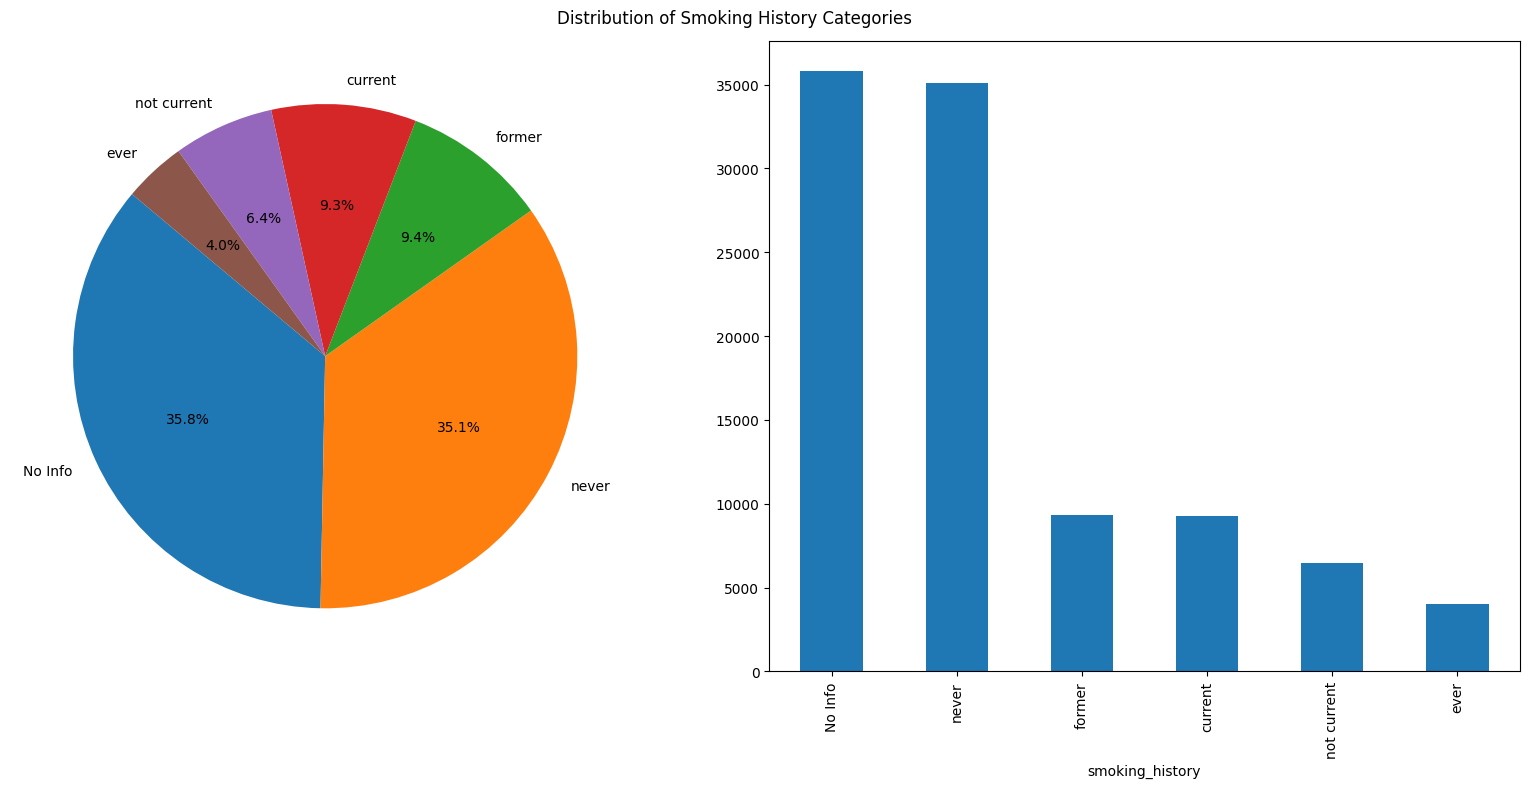

In [54]:
counts = df['smoking_history'].value_counts()

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)

plt.subplot(1, 2, 2)
counts.plot(kind='bar')

plt.suptitle('Distribution of Smoking History Categories')
plt.tight_layout()
plt.show()

As the graph above shows, the *No Info* category represents around 35 000 observations. Since this category represents 35.8% of the smoking history feature, we're not going to delete the observations which contains *No Info*. We could consider replacing these instances by other categories. However, again given the proportion of 35.8% in the dataset represented by the *No Info* category, such a replacement strategy could introduce bias if we do it wrong. We still have to encode this feature. To do so, we use [*OneHotEncoder*](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) from *sklearn.preprocessing* library to create 6 new columns for each category in this feature.

In [55]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

encoded = enc.fit_transform(df[['smoking_history']])
encoded_df = pd.DataFrame(encoded, columns = enc.get_feature_names_out(['smoking_history']))

df = pd.concat([df, encoded_df], axis = 1)
df = df.drop(columns='smoking_history')


## Gender 

Let's take a look on the Gender distribution. 

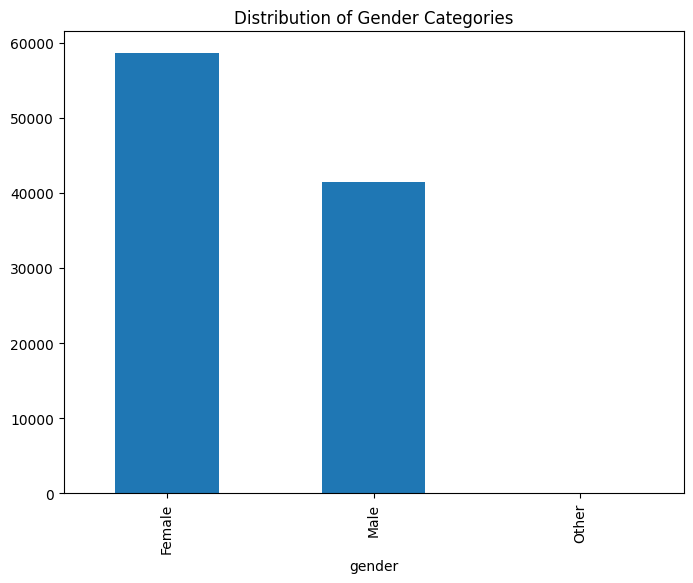

In [56]:
counts_gender = df['gender'].value_counts()
plt.figure(figsize=(8, 6))
counts_gender.plot(kind='bar')
plt.title('Distribution of Gender Categories')
plt.show()

As the graph above shows, only a few observations are set to *other* for the sex, so this time we're going to replace them by the most represented gender, i.e. *female*. Then, again we encode the data. 

In [57]:
df['gender'] = df['gender'].replace('Other', 'Female')

df['gender'] = df['gender'].map({'Female' : 1, 'Male' : 0})



## Output distribution 

Let's take a look on the target distribution

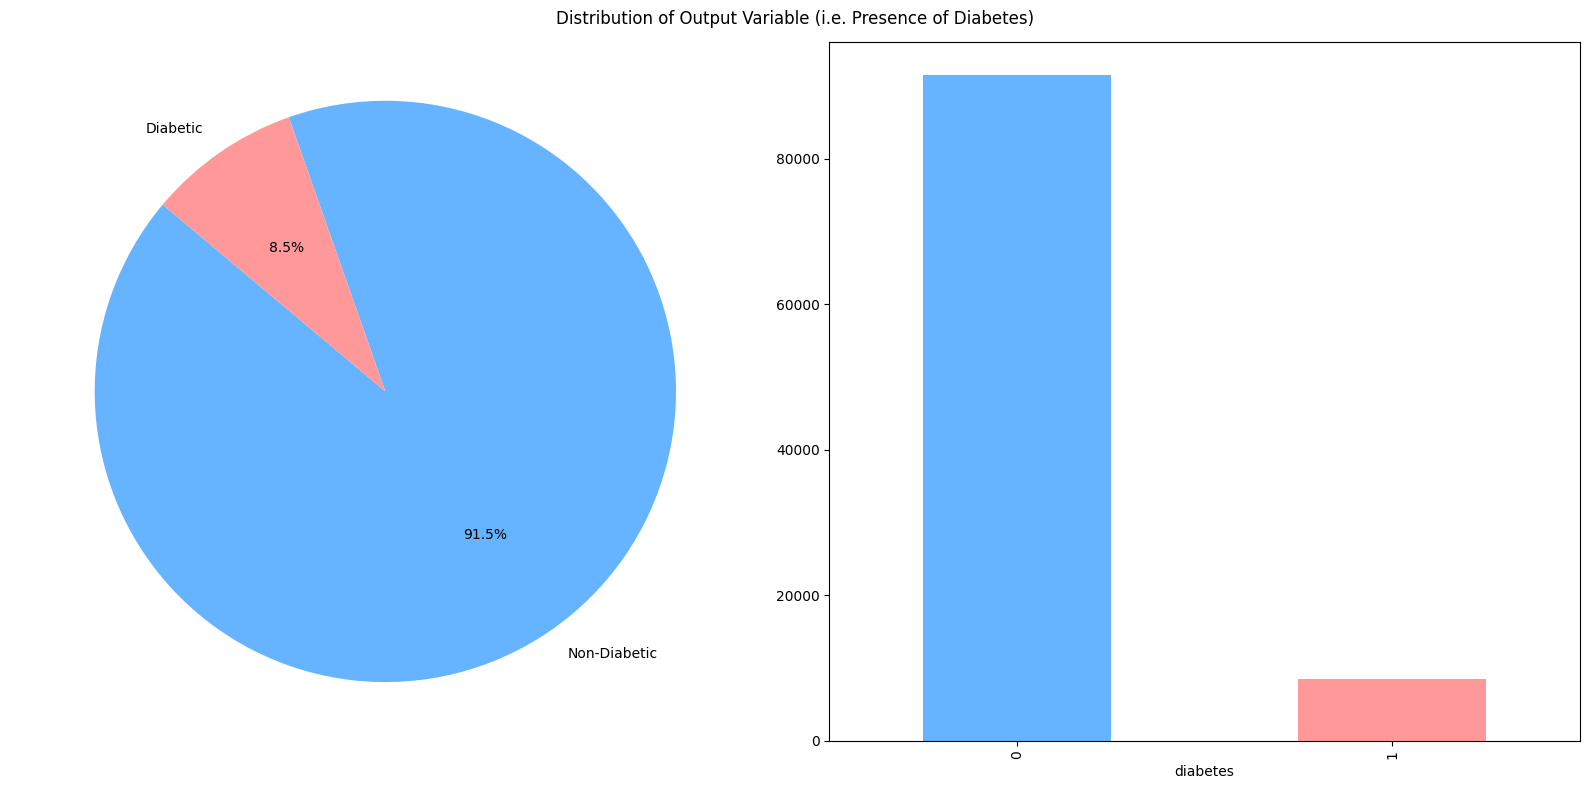

In [58]:
counts_output = df['diabetes'].value_counts()



plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.pie(counts_output, labels=['Non-Diabetic', 'Diabetic'], autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#ff9999'])
plt.axis('equal')


plt.subplot(1, 2, 2)
counts_output.plot(kind='bar', color=['#66b3ff', '#ff9999'])

plt.suptitle('Distribution of Output Variable (i.e. Presence of Diabetes)')
plt.tight_layout()
plt.show()

As we can see we have an unbalanced distribution for our target. So we've to take it into consideration during our analysis.

## Data Splitting & Standardization 

First we have to split our data set. One part will be the features $X$ and the other part will be the target values $y$ (presence of diabete). Then we split the dataset into a traning sample $X_{train}$ and $y_{train}$ and test sample $X_{test}$ and $y_{test}$. To do so, we use [*train_test_split*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from *sklearn.model_selection*


In [59]:
from sklearn.model_selection import train_test_split

X = df.drop(['diabetes'], axis = 1).values

y = df['diabetes'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)



We are going to standarize the data. To do so we use the [ *StandardScaler*](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from *sklearn.preprocessing* library which uses the following formula :

 <br>

$$
\boxed{X_{scaled} = \frac{X - \mu}{\sigma}}
$$
Where:
- $X_{scaled}$ is the standardized value of the feature
- $X$ is the value of the feature
- $\mu$ is the mean of the traning samples
- $\sigma$ is the standard deviation of the training samples 

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



# Model


To predict the presence of diabete we are going to train, evaluate and compare 3 models : **Logistic Regression**, **Gradient Boosting** and **Neural Network**. To evaluate and compare the models we are going to use various metrics from [*sklearn.metrics*](https://scikit-learn.org/stable/modules/model_evaluation.html). Since we are considering a classification problem, we use classification scoring for evalutation and comparaison.

- [**F1 score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) : As seen in Data processing section, we have an unbalanced output. Indeed we have 91.5% of non-diabetic cases and 8.5% of diabitic cases. That's why we use F1 score which is particularly useful in unbalanced class situations. F1 Score is computed as followed: 
    $$
    \boxed{F1 = \frac{2\times TP}{2\times TP + FP + FN}}
    $$
    With:
    <br>
    
    - TP : Number of true positives
    - FP : Number of false positives
    - FN : Number of false negatives
    
<br>

- [**Precision**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) : We are trying to predict if a person has the diabete or not, so we want to avoid falsely diagnosing people as diabetic. Since Precision tells us the proportion of true diabetic cases among the predicted positive cases, it's a good scoring tool for seeing the proportion of false diagnoses of diabetes predicted. Precision is computed as followed:
    $$
    \boxed{Precision = \frac{TP}{TP + FP}}
    $$

- [ **Recall**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) : We also and mainly want to avoid falsely diagnosing people as a non-diabetic. Since Recall tells us the proportion of true diabetic cases that are correctly identified, it's a good scoring tool for seeing the impact of false diagnoses of non-diabetic. Recall is computed as followed:
    $$
    \boxed{Recall = \frac{TP}{TP + FN}}
    $$

- [ **Confusion Matrix**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html): It shows us the absolute numbers of true positives, false positives, true negatives, and false negatives. It gives a detailed view of the errors the model makes.



In [61]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

 ## Logistic Regression 

 To define our Logistic Regression model we use the [*Logistic Regression*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class from *sklearn.linear_model*. We train several model using the [*GridSearchCV*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class form *sklearn.model_selection* to find the best hyperparameters. We try various values of the following parameters : 
 - **Penalty** : It specifies the type of regularization applied to the model to prevent  overfitting by adding a penalty to the loss function.
 - **C** : It controls the strenght of the regularization. (It's the inverse of the regularization strength)
 - **Class weight** : It adjusts the weights associated with classes to handle imbalanced datasets by assigning a higher penalty to misclassifications of underrepresented classes.


In [62]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression() 


param_grid_lr = {
    'penalty':  ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight' : [None, 'balanced']
    }

grid_search_lr = GridSearchCV(lr, param_grid = param_grid_lr, cv = 5)
grid_search_lr.fit(X_train_scaled, y_train)


print("Best hyperparameters :", grid_search_lr.best_params_)

Best hyperparameters : {'C': 0.01, 'class_weight': None, 'penalty': 'l2'}


We've found the best hyperparameters for our Logistic Regression model, now we can fit our model with theses best hyperparameters and predict the test samples

In [63]:
lr_best_param = LogisticRegression(penalty = 'l2', C = 0.01, class_weight = None)
lr_best_param.fit(X_train_scaled, y_train)

prediction_lr_test = lr_best_param.predict(X_test_scaled)


F1 Score :  0.7233459033253342
Precision Score :  0.866885784716516
Recall Score :  0.6205882352941177


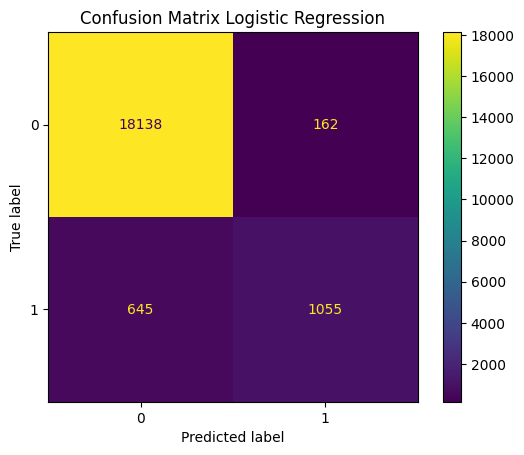

In [64]:
f1_score_lr = f1_score(y_test, prediction_lr_test)
precision_score_lr = precision_score(y_test, prediction_lr_test)
recall_score_lr = recall_score(y_test, prediction_lr_test)


print("F1 Score : ", f1_score_lr)
print("Precision Score : ", precision_score_lr)
print("Recall Score : ", recall_score_lr)

cm_lr = confusion_matrix(y_test, prediction_lr_test, labels = lr_best_param.classes_)
disp_conf_lr = ConfusionMatrixDisplay(confusion_matrix = cm_lr, display_labels = lr_best_param.classes_)


disp_conf_lr.plot()
plt.title("Confusion Matrix Logistic Regression")
plt.show()

## Gradient Boosting

 To define our Gradient Boosting model we use the [*HistGradientBoostingClassifier*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) class from *sklearn.ensemble* which run much faster than [*GradientBoostingClassifier*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier). We train several model using the [*GridSearchCV*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class form *sklearn.model_selection* to find the best hyperparameters. We try various values of the following parameters : 
 - **Max iter** : The maximum number of iterations of the boosting process, i.e. the maximum number of trees for binary classification.
 - **Max depth** : The maximum depth of each tree. The depth of a tree is the number of edges to go from the root to the deepest leaf. (To avoid overfitting)


In [67]:
from sklearn.ensemble import HistGradientBoostingClassifier

gb = HistGradientBoostingClassifier()


param_grid_gb = {
    'max_iter': [100, 300, 700, 1000, 2000],  
    'max_depth' : [5, 10, 15, 20]
 
}

grid_search_gb = GridSearchCV(estimator = gb, param_grid = param_grid_gb, cv = 5, n_jobs = -1)
grid_search_gb.fit(X_train_scaled, y_train)


print("Best hyperparameters : ", grid_search_gb.best_params_)

Best hyperparameters :  {'max_depth': 5, 'max_iter': 700}


We've found the best hyperparameters for our Gradient Boosting model, now we can fit our model with these best hyperparameters and predict the test samples

In [68]:
gb_best_param = HistGradientBoostingClassifier(max_iter = 700, max_depth = 5)
gb_best_param.fit(X_train_scaled, y_train)

prediction_gb_test = gb_best_param.predict(X_test_scaled)

F1 Score :  0.808848945731075
Precision Score :  0.980720871751886
Recall Score :  0.6882352941176471


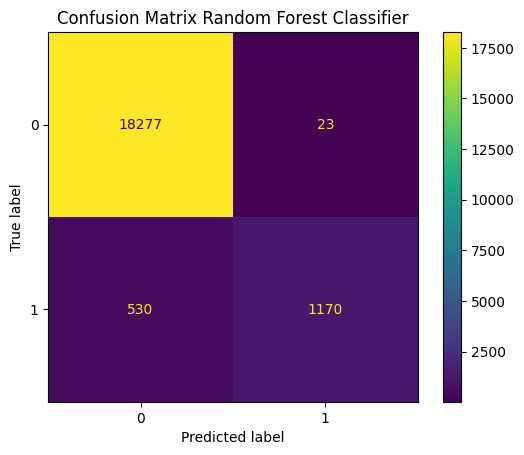

In [69]:
f1_score_gb = f1_score(y_test, prediction_gb_test)
precision_score_gb = precision_score(y_test, prediction_gb_test)
recall_score_gb = recall_score(y_test, prediction_gb_test)


print("F1 Score : ", f1_score_gb)
print("Precision Score : ", precision_score_gb)
print("Recall Score : ", recall_score_gb)


cm_gb = confusion_matrix(y_test, prediction_gb_test, labels = gb_best_param.classes_)
disp_conf_gb = ConfusionMatrixDisplay(confusion_matrix = cm_gb, display_labels = gb_best_param.classes_)


disp_conf_gb.plot()
plt.title("Confusion Matrix Random Forest Classifier")
plt.show()

## Neural Network

 To define our Neural Network model we use the [*MLPClassifier*](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) class from *sklearn.neural_network*. We train several model using the [*GridSearchCV*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class form *sklearn.model_selection* to find the best hyperparameters. We try various values of the following parameter : 
 - **Hidden layer sizes** : It specifies the number and size of the hidden layers in the neural network

In [70]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

param_grid_mlp = {
    'hidden_layer_sizes': [(32,), (64,), (32, 32), (64, 64), (32, 64, 32)]
}

grid_search_mlp = GridSearchCV(estimator = mlp, param_grid = param_grid_mlp, cv = 5, n_jobs = -1)
grid_search_mlp.fit(X_train_scaled, y_train)

print("Best hyperparameters : ", grid_search_mlp.best_params_)


Best hyperparameters :  {'hidden_layer_sizes': (64,)}


We've found the best hyperparameters for our Neural Network model, now we can fit our model with theses best hyperparameters and predict the test samples

In [71]:
mlp_best_param = MLPClassifier(hidden_layer_sizes=(64,))
mlp_best_param.fit(X_train_scaled, y_train)

prediction_mlp_test = mlp_best_param.predict(X_test_scaled)

F1 Score :  0.8073204419889503
Precision Score :  0.9774247491638796
Recall Score :  0.6876470588235294


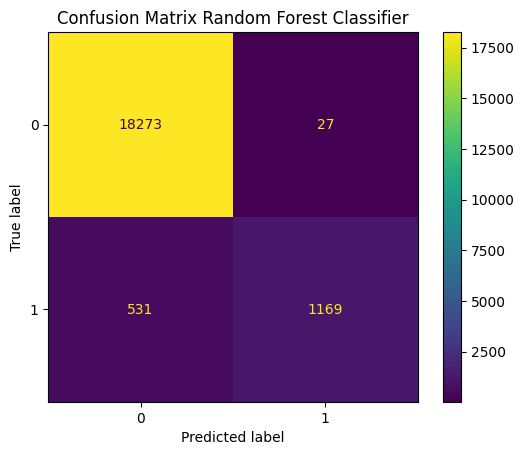

In [72]:
f1_score_mlp = f1_score(y_test, prediction_mlp_test)
precision_score_mlp = precision_score(y_test, prediction_mlp_test)
recall_score_mlp = recall_score(y_test, prediction_mlp_test)

print("F1 Score : ", f1_score_mlp)
print("Precision Score : ", precision_score_mlp)
print("Recall Score : ", recall_score_mlp)


cm_mlp = confusion_matrix(y_test, prediction_mlp_test, labels = mlp_best_param.classes_)
disp_conf_mlp = ConfusionMatrixDisplay(confusion_matrix = cm_mlp, display_labels = mlp_best_param.classes_)


disp_conf_mlp.plot()
plt.title("Confusion Matrix Random Forest Classifier")
plt.show()

# Comparison

